In [1]:
using Pkg, Logging
Pkg.activate(@__DIR__)
push!(LOAD_PATH, joinpath(@__DIR__, "..", ".."))
push!(LOAD_PATH, joinpath(@__DIR__, "..", "..", "extras"));

In [2]:
Pkg.instantiate()
with_logger(NullLogger()) do
    pkg"precompile"
end

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...


In [3]:
using MeshCatMechanisms
using RigidBodyDynamics
using RigidBodyDynamics: Bounds, lower, upper

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/29d4a42ceb6d03d53ba5feb8981c0eb5bceb5139-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/29d4a42ceb6d03d53ba5feb8981c0eb5bceb5139-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [4]:
urdf = joinpath(dirname(pathof(RigidBodyDynamics)), "..", "test", "urdf", "Acrobot.urdf")
mechanism = parse_urdf(urdf, revolute_joint_type=SinCosRevolute{Float64})
shoulder, elbow = joints(mechanism);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));

In [29]:
effort_bounds(shoulder) .= Bounds(0.0, 0.0)
effort_bounds(elbow) .= Bounds(-10.0, 10.0);

In [30]:
with_logger(NullLogger()) do
    open(mvis)
end

/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'http://127.0.0.1:8701'


Could not open browser automatically: ErrorException("failed process: Process(`xdg-open http://127.0.0.1:8701`, ProcessExited(3)) [3]")
Please open the following URL in your browser:
http://127.0.0.1:8701


Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")┌ Info: Closed:  💀    1↑     1↓🔒 2619s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:373


In [31]:
using MINLPTrajOpt
using JuMP
using BARONTools

In [32]:
using BARON

N = 60
objective = MinEffort()
T = objective isa MinEffort ? 4.5 : nothing
fixedstep = objective isa MinEffort

if fixedstep
    Δt = T / N
    Δtmin = Δt
    Δtmax = Δt
else
    Δtmin = 1e-3
    Δtmax = 0.5
end
Δθmax = 0.6#vmax * Δtmin

x0 = MechanismState(mechanism)
# set_configuration!(x0, shoulder, 0.05)
set_configuration!(x0, shoulder, 0.1)
set_configuration!(x0, elbow, 0.0)
zero_velocity!(x0)
# rand_configuration!(x0)

xf = MechanismState(mechanism)
set_configuration!(xf, shoulder, π)
set_configuration!(xf, elbow, 0.0)
zero_velocity!(xf)

solver = BaronSolver(threads=Sys.CPU_THREADS, MaxTime=10 * 60.0, PrTimeFreq=5.)
problem = TrajOptProblem(mechanism, x0, solver;
    xf=xf, Δtmin=Δtmin, Δtmax=Δtmax, T=T, N=N, Δθmax=Δθmax, objective=objective);

In [33]:
copyto!(mvis, x0)

In [34]:
solve(problem.model)

 BARON version 18.8.23. Built: LNX-64 Thu Aug 23 14:46:44 EDT 2018

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: MIT at Twan Koolen, tkoolen@mit.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP: ILOG CPLEX                                      
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Using CPLEX library libcplex1280.so.
 Preprocessing found feasible solution with value  41.3467246663     
 Solving bounding LP
 Starting multi-start local search
 Estimated remaining time for local search is 4 secs
 Done with loc

:Optimal

In [35]:
ts = [0; cumsum(getvalue.(problem.Δts))]
qs = [Vector(configuration(x0)), getvalue.(problem.qs)...]
Δqs = getvalue.(problem.Δqs)
τs = getvalue.(problem.τs);

In [36]:
using LaTeXStrings
using PGFPlotsX
using PlottingTools
PGFPlotsX.latexengine!(PGFPlotsX.PDFLATEX);

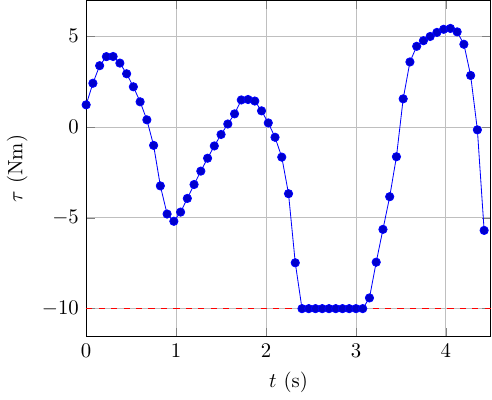

In [37]:
p = timeplot(ts[1 : end - 1], [τ[2] for τ in τs]; ylabel=L"$\tau$ (Nm)", tmax=ts[end])
push!(p, @pgf HLine({dashed, red, thick}, upper(effort_bounds(elbow)[1])))
push!(p, @pgf HLine({dashed, red, thick}, lower(effort_bounds(elbow)[1])))
# save_data && pgfsave(joinpath(datadir, "tau.pdf"), p)
p

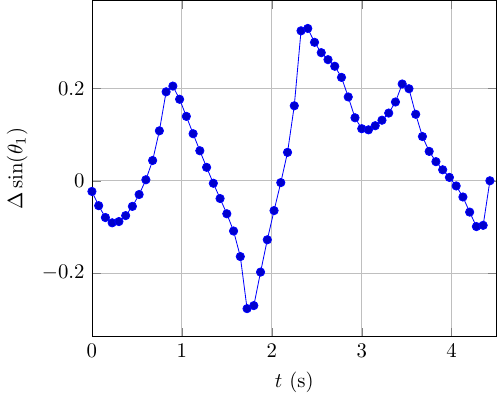

In [46]:
p = timeplot(ts[1 : end - 1], [Δq[1] for Δq in Δqs]; ylabel=L"$\Delta \sin(\theta_1)$", tmax=ts[end])

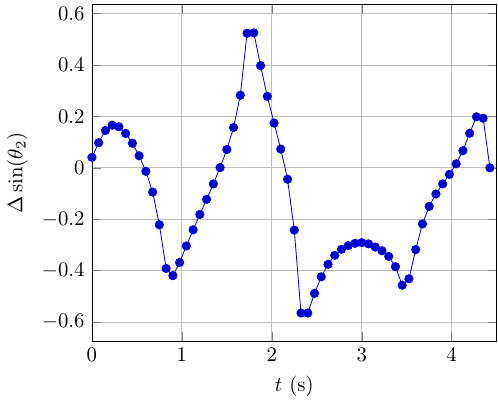

In [47]:
p = timeplot(ts[1 : end - 1], [Δq[3] for Δq in Δqs]; ylabel=L"$\Delta \sin(\theta_2)$", tmax=ts[end])

In [43]:
setanimation!(mvis, ts, qs)

┌ Info: Closed:  💀    1↑     1↓🔒 122s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:373
┌ Info: Closed:  💀    5↑     5↓🔒 122s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:373


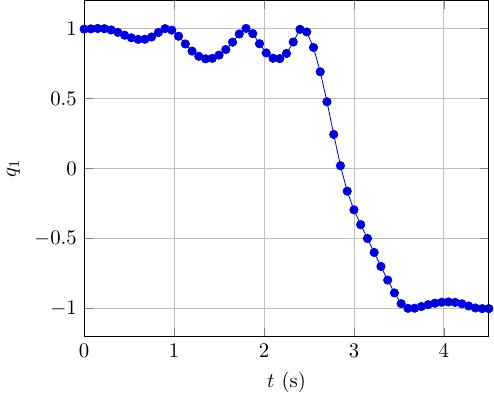

In [41]:
p = timeplot(ts, [q[2] for q in qs]; ylabel=L"$q_1$", tmax=ts[end])

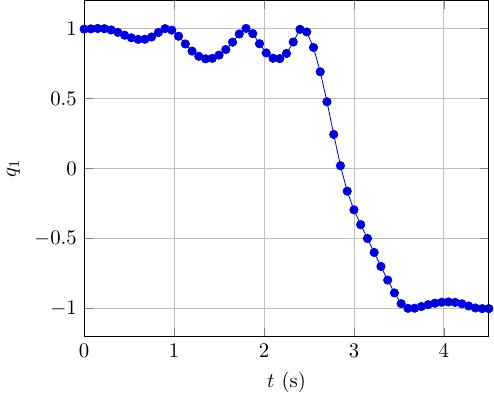

┌ Info: Accept:  🔗    0↑     0↓    0s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:366
┌ Info: Accept:  🔗    0↑     0↓    0s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:366
┌ Info: Accept:  🔗    0↑     0↓    0s 127.0.0.1:8700:8700 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:366


In [42]:
p = timeplot(ts, [q[2] for q in qs]; ylabel=L"$q_1$", tmax=ts[end])